In [ ]:
pip install pyomo

In [2]:
pip install networkx

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [41]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.contrib.fbbt.fbbt import fbbt
import time
import matplotlib.pyplot as plt
import networkx as nx   #library to model graphs. Cool because can tell you which nodes are neighbours to the other.
import numpy as np
from dataclasses import dataclass
import pyomo.environ as pyo   #moddeling language
import linopy
import xarray as xr
import pandas as pd
from linopy import Model
from itertools import combinations


In [42]:
#Helping functions :
def plot(G, title="Graph"):
    pos = nx.get_node_attributes(G, 'pos')
    if not pos:
        print("No position data found.")
    else:
        plt.figure(figsize=(6, 6))
        nx.draw(G, pos, with_labels=True, node_size=300, alpha=0.8, arrows=True)
        plt.title(title)
        plt.gca().set_aspect('equal')
        plt.show()

In [43]:
#Chosse the day  ( winter = 25 february = 56) (spring = 3 april = 93) (summer = 20 July = 201)
day = 56

In [44]:
#Import data on conductors
conductors_df = pd.read_csv("./cables_types.csv", index_col=0)
conductors = conductors_df.to_xarray()

#Import data on Buses
Bus_pos_df = pd.read_csv("./buses.csv", index_col=0)
Bus_position = Bus_pos_df.to_xarray()

#Import data on days considered.
if day == 56:
    P_demand_df = pd.read_csv("./P_demand_Buses_winter.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_winter.csv",index_col=0)
elif day == 93:
    P_demand_df = pd.read_csv("./P_demand_Buses_spring.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_spring.csv",index_col=0)
elif day == 201:
    P_demand_df = pd.read_csv("./P_demand_Buses_summer.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_xummer.csv",index_col=0)
else:
    print("error : chosen day not in the data.")

P_demand = P_demand_df.to_xarray()
Q_demand = Q_demand_df.to_xarray()

    

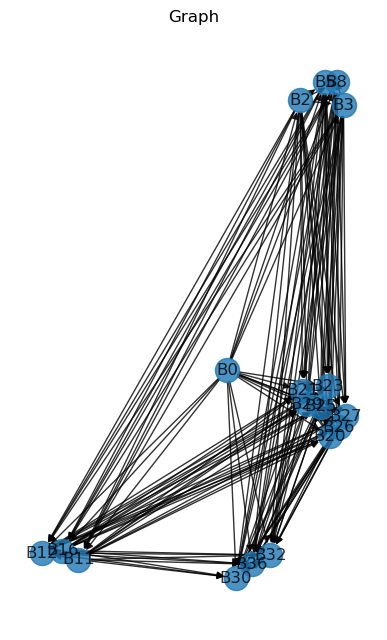

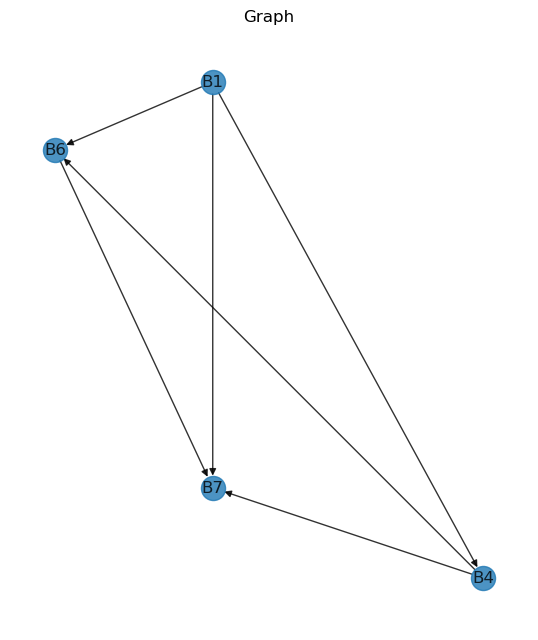

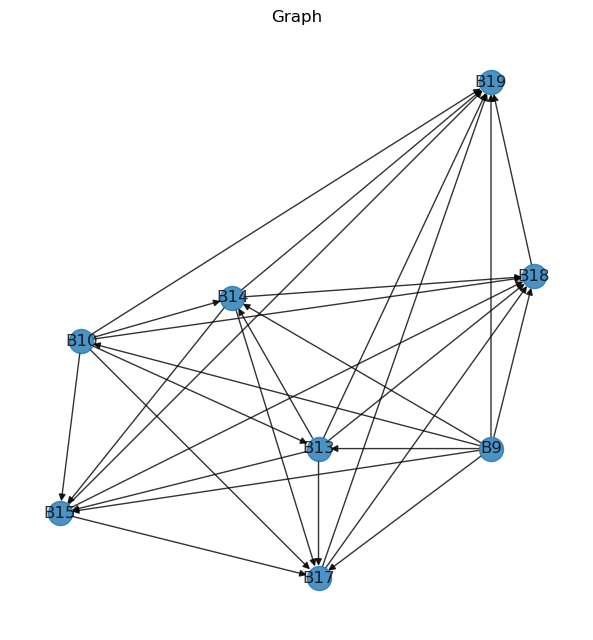

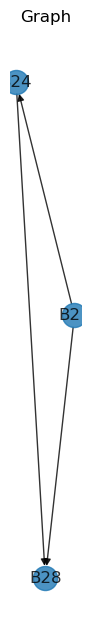

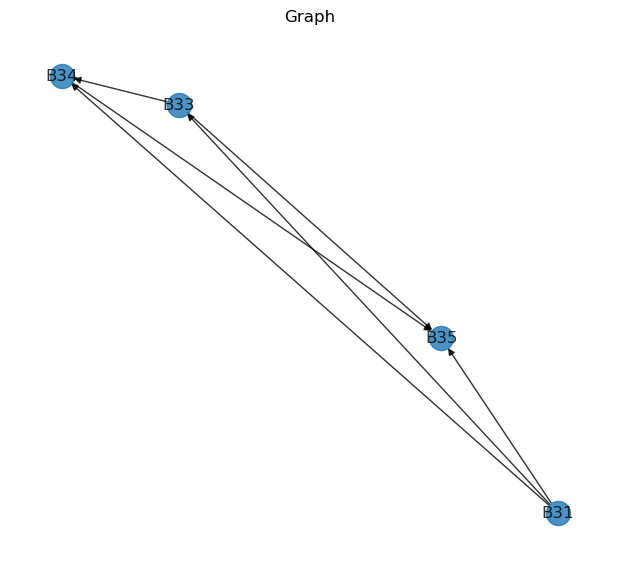

In [45]:
#Bus geometry implementation
Bus_ID = Bus_position["Building ID"].values
X = Bus_position["X"].values/100
Y = - Bus_position["Y"].values/100
network_voltage = Bus_position["Voltage"].values
zone = Bus_position["zone"].values


G_15kV = nx.DiGraph()


zones = ["Dupéré", "Overdale", "Hochelaga", "Anjou"] #
G_0_4kV_by_zone = {z: nx.DiGraph() for z in zones}

# Iterate using index over the NumPy arrays
for i in range(len(Bus_ID)):
    bus_id = Bus_ID[i]
    pos = (X[i], Y[i])
    voltage = network_voltage[i]
    current_zone = zone[i]

    if voltage == 15:
        G_15kV.add_node(bus_id, P=0.0, pos=pos)

    if voltage == 0.4 and current_zone in zones:
        G_0_4kV_by_zone[current_zone].add_node(bus_id, P=0.0, pos=pos)


        # Add edges between all nodes in G_15kV
for u, v in combinations(G_15kV.nodes, 2):
    G_15kV.add_edge(u, v)
    # G_15kV.add_edge(v, u)

# Add edges within each zone-specific graph
for z in zones:
    G_zone = G_0_4kV_by_zone[z]
    for u, v in combinations(G_zone.nodes, 2):
        G_zone.add_edge(u, v)
        # G_zone.add_edge(v, u)

plot(G_15kV)
for z in zones:
    plot(G_0_4kV_by_zone[z])

In [55]:
#Model initialisation
model = AbstractModel()


# Assumptions : 
3 representative days (summer, winter, spring) with a 24 hour time step t.\
2 voltage levels ( 15 kv and O.4 kv ) consider as separated networks\
PV panels and storage are connected but not optimize.\
PV production is assumed uniform and only present in the low voltage networks.\
3 types of conductors for the lines.\

# Sets : 
Omega b : set of nodes/buses\
Omega l : set of lines\
Omega s : set of substations\
Omega a : set of line types ( 3 )\
D : set of days ( 3 )\
T: set of time steps ( 24 )



# Indices :
a : Conductor type\
t: Time step\
d : day\
i,j,k : Nodes

In [56]:
# Set of conductor types (Ω_a)
model.conductor_types = Set(doc="Set of conductor types (Ω_a)")

# Set of time steps (T = {1, ..., 24})
model.time_steps = Set(doc="Set of time steps (T)")

# Set of representative days (D = {1, 2, 3}) e.g., Summer, Winter, Spring
model.days = Set(doc="Set of representative days (D)")

# Set of buses or nodes (Ω_b)
model.buses = Set(doc="Set of buses (Ω_b)")

# Set of substations (Ω_s ⊆ Ω_b)
model.substations = Set(within=model.buses, doc="Set of substations (Ω_s ⊆ Ω_b)")

# Set of distribution lines (Ω_l ⊆ Ω_b × Ω_b)
model.lines = Set(dimen=2, doc="Set of lines (Ω_l ⊆ Ω_b × Ω_b)")

## Parameters :

In [57]:
#Planning horizon
model.PLANNING_HORIZON = Param(doc="Planning horizon in years") # 1 year ?
model.HOURS_PER_YEAR = Param(doc="Hours per year") # 8760

# Capital recovery rates
model.KAPPA_L = Param(doc="Capital recovery rate for line construction") 
model.KAPPA_S = Param(doc="Capital recovery rate for substation construction")
model.KAPPA_C = Param(doc="Capital recovery rate for capacitor construction")

#Interest rate
model.INTEREST_PLOSS = Param(doc="Interest rate for real power loss costs")
model.INTEREST_SUB = Param(doc="Interest rate for substation operational costs")


# Voltage drop bound if line not used
model.b_max = Param(doc="Voltage drop bound for inactive circuits")

# Installation costs, etc.
model.CF = Param(doc="Installation cost of fixed capacitor banks")
model.CSI = Param(model.substations, doc="Fixed cost of substation at node i")
model.CVI = Param(model.substations, doc="Operational cost of substation at node i per (kW)^2 per hour")
model.CLINE = Param( model.lines, model.conductor_types, doc="Construction cost for line (i,j) with conductor a ")
model.CUN = Param(doc="Annualized cost per standard capacitor unit")

# Energy cost
model.CL = Param(doc="Energy cost in USD/kWh")

# Line
model.LENGTH = Param(model.lines, doc="Length of each line (km)")
model.I_MAX = Param(model.conductor_types, doc="Maximum current for each conductor type")
model.R = Param(model.conductor_types, doc="Resistance per km for each conductor type")
model.X = Param(model.conductor_types, doc="Reactance per km for each conductor type")
model.Z = Param(model.conductor_types, doc="Impedance per km for each conductor type")

# Total max number of capacitor banks
model.N_CAP_TOTAL = Param(doc="Total maximum number of capacitor banks")
# Max number of capacitor units per bus
model.N_CAP_MAX = Param(model.buses, doc="Maximum number of capacitor units per bus")

#Maximum apparent power
model.SG = Param(model.buses, doc="Maximum apparent power limit of substation construction at node i")

# Voltage limits 
model.V_MIN = Param(doc="Minimum voltage magnitude")
model.V_MAX = Param(doc="Maximum voltage magnitude")

# Power demand at each bus
model.P_DEMAND = Param(model.buses, model.time_steps, model.days, doc="Active power demand at each bus")
model.Q_DEMAND = Param(model.buses, model.time_steps, model.days, doc="Reactive power demand at each bus")

#Active power generation at node i at time t ( PV panels )
model.P_GEN = Param(model.buses, model.time_steps, model.days, doc="Active power generation at node i at time t during day d")


'''
#Max charge and discharge power of the batteries at each node
model.MAX_CHARGE = Param( model.buses, doc="Maximum charge power of batteries at each node")
model.MAX_DISCHARGE = Param( model.buses, doc="Maximum discharge power of batteries at each node")

#Storage capacities limits
model.MAX_STO = Param( model.buses, doc="Maximum storage capacity")
model.MIN_STO = Param( model.buses, doc="Minimum storage capacity")

model.CHARGE_EFF = Param( doc="Charge efficiency of the batteries")
model.DISCHARGE_EFF = Param( doc="Discharge efficiency of the batteries")
#Initial storage
model.STO_INI = Param( doc="Initial state of the storage")

# Reactive power per capacitor unit 
model.Q_PER_CAP = Param( doc="Reactive power provided by one capacitor unit")
'''




'''
#Power supply at each bus
model.P_SUPPLY = Param(model.buses, model.time_steps, model.days, doc="Active power supplied at each bus")
model.Q_SUPPLY = Param(model.buses, model.time_steps, model.days, doc="Reactive power supplied at each bus")
'''


## Variables :

In [58]:
#Currents
model.i_squared_cond = Var(model.lines, model.time_steps, model.days, model.conductor_types, within=NonNegativeReals)
model.i_squared = Var(model.lines, model.time_steps, model.days, within=NonNegativeReals)

#Voltages
model.v_squared = Var(model.buses, model.time_steps, model.days, within=NonNegativeReals)

#Squared Apparent power at substation
model.s_sub_squared = Var(model.substations, model.time_steps, model.days, within=NonNegativeReals)

# Active power flow on line (i,j) with conductor a
model.p_flow = Var(model.lines, model.time_steps, model.days, model.conductor_types)
model.q_flow = Var(model.lines, model.time_steps, model.days, model.conductor_types)

#real power flow
model.p_flow_total = Var(model.lines, model.time_steps, model.days)
model.q_flow_total = Var(model.lines, model.time_steps, model.days)

#Power provided by substation
model.p_sub = Var(model.substations, model.time_steps, model.days)
model.q_sub = Var(model.substations, model.time_steps, model.days)

model.voltage_drop_term = Var(model.lines)

#Number of standard capacitor units at node i
model.n_cap = Var(model.buses, within=NonNegativeIntegers)

model.q_cap_installed = Var(model.buses, within=Binary)


#binary variables line direction
model.line_active_forward = Var(model.lines,model.time_steps, model.days, within=Binary)
model.line_active_reverse = Var(model.lines,model.time_steps, model.days, within=Binary)

model.conductor_selected = Var(model.lines, model.conductor_types, within=Binary)

model.substation_built = Var(model.substations, within=Binary)
'''
#Batteries
model.p_charge = Param( model.buses, model.time_steps, model.days, within=NonNegativeReals)
model.p_discharge = Param( model.buses, model.time_steps, model.days, within=NonNegativeReals)
model.sto_state = Param( model.buses, model.time_steps, model.days)
'''

## Objective Function : 

In [59]:
def capital_recovery_factor(model, interest_rate, planning_horizon):
    return (1 - (1 + interest_rate) ** (-planning_horizon)) / interest_rate
model.capital_recovery_factor = capital_recovery_factor


def objective_function_rule(model):
    substation_cost = sum(
        model.KAPPA_S * model.CSI[i] * model.substation_built[i] +
        (model.HOURS_PER_YEAR / 72) * model.capital_recovery_factor(model.INTEREST_RATE_S, model.PLANNING_HORIZON) *
        model.CVI[i] * sum(model.s_squared[i, t, d] for t in model.time_steps for d in model.days)
        for i in model.substations
    )

    line_cost = sum(
        model.KAPPA_L * model.cost_line[i, j, a] * model.conductor_selected[i, j, a] +
        (model.HOURS_PER_YEAR / 72) * model.capital_recovery_factor(model.INTEREST_RATE_L, model.PLANNING_HORIZON) *
        model.R[a] * model.CL * sum(model.i_squared[i, j, t, d, a] for t in model.time_steps for d in model.days)
        for (i, j) in model.lines for a in model.conductor_types
    ) * model.LENGTH[i, j]

    capacitor_cost = sum(
        model.CK * model.q_cap_installed[i] + model.CUN * model.n_cap[i]
        for i in model.buses
    )

    return substation_cost + line_cost + capacitor_cost

model.objective = Objective(rule=objective_function_rule, sense=minimize)

## Constraints

In [60]:
# Constraint : Real Power Balance 
def real_power_balance_rule(model, i, t, d):
    inflow = sum(model.p_flow[k, i, t, d, a] for (k, i2) in model.lines if i2 == i for a in model.conductor_types)
    outflow = sum(model.p_flow[i, j, t, d, a] + model.R[a] * model.LENGTH[i, j] * model.i_squared[i, j, t, d, a]
                  for (i2, j) in model.lines if i2 == i for a in model.conductor_types)
    return inflow - outflow + model.p_sub[i, t, d] + model.P_GEN[i, t, d] - model.p_charge[i,t,d] + model.p_discharge[i,t,d] == model.P_DEMAND[i, t, d]
model.real_power_balance = Constraint(model.buses, model.time_steps, model.days, rule=real_power_balance_rule)

# Constraint : Reactive Power Balance 
def reactive_power_balance_rule(model, i, t, d):
    inflow = sum(model.q_flow[k, i, t, d, a] for (k, i2) in model.lines if i2 == i for a in model.conductor_types)
    outflow = sum(model.q_flow[i, j, t, d, a] + model.X[a] * model.LENGTH[i, j] * model.i_squared[i, j, t, d, a]
                  for (i2, j) in model.lines if i2 == i for a in model.conductor_types)
    return inflow - outflow + model.q_sub[i, t, d] + model.Q_PER_CAP[t, d] * model.n_cap[i] == model.Q_DEMAND[i, t, d]
model.reactive_power_balance = Constraint(model.buses, model.time_steps, model.days, rule=reactive_power_balance_rule)

# Constraint : Voltage 
def voltage_drop_rule(model, i, j, t, d):
    drop = sum(2 * (model.R[a] * model.p_flow[i, j, t, d, a] + model.X[a] * model.q_flow[i, j, t, d, a]) * model.LENGTH[i, j] +
               (model.Z[a] ** 2) * (model.LENGTH[i, j] ** 2) * model.i_squared[i, j, t, d, a] for a in model.conductor_types)
    return model.v_squared[i, t, d] - model.v_squared[j, t, d] == drop + model.voltage_drop_term[i, j,t,d]
model.voltage_drop = Constraint(model.lines, model.time_steps, model.days, rule=voltage_drop_rule)
def voltage_min_rule(model, i, t, d):
    return model.V_MIN**2 <= model.v_squared[i,t,d]
model.voltage_min = Constraint(model.buses, model.time_steps, model.days, rule=voltage_min_rule)
def voltage_max_rule(model, i, t, d):
    return model.V_MAX**2 >= model.v_squared[i,t,d]
model.voltage_max = Constraint(model.buses, model.time_steps, model.days, rule=voltage_max_rule)

def voltage_drop_limit_rule(model, i, j,t,d):
    return abs(model.voltage_drop_term[i, j,t,d]) <= model.b_max * (1 - model.line_active_forward[i, j,t,d] - model.line_active_reverse[i, j,t,d])
model.voltage_drop_limit = Constraint(model.lines, model.time_steps, model.days, rule=voltage_drop_limit_rule)

#Constraint : Current
def current_max_limit(model, i, j, t, d, a):
    return model.i_squared_cond <= model.I_MAX[a]**2 *(model.line_active_forward[i, j,t,d] + model.line_active_reverse[i, j,t,d])
model.current_max = Constraint(model.lines, model.time_steps, model.days, rule=current_max_limit)

def current_limit_with_conductor_rule(model, i, j, t, d, a):
    return model.i_squared_cond[i, j, t, d, a] <= model.I_MAX[a]**2 * model.conductor_selected[i, j, a]
model.current_limit_with_conductor = Constraint(model.lines, model.time_steps, model.days, model.conductor_types, rule=current_limit_with_conductor_rule)

# Constraint : Power Flow Quadratic Relation
def power_flow_quadratic_rule(model, i, j, t, d):
    return model.v_squared[j, t, d] * model.i_squared[i, j, t, d] >= model.p_flow_total[i, j, t, d]**2 + model.q_flow_total[i, j, t, d]**2
model.power_flow_quadratic = Constraint(model.lines, model.time_steps, model.days, rule=power_flow_quadratic_rule)

# Constraint : power flow limit
def active_power_forward_limit_rule(model, i, j, t, d, a):
    return model.p_flow[i, j, t, d, a] <= model.V_MAX * model.I_MAX[a] * model.line_active_forward[i, j]
model.active_power_forward_limit = Constraint(model.lines, model.time_steps, model.days, model.conductor_types, rule=active_power_forward_limit_rule)

def active_power_reverse_limit_rule(model, i, j, t, d, a):
    return model.p_flow[i, j, t, d, a] >= -model.V_MAX * model.I_MAX[a] * model.line_active_reverse[i, j]
model.active_power_reverse_limit = Constraint(model.lines, model.time_steps, model.days, model.conductor_types, rule=active_power_reverse_limit_rule)

def reactive_power_limit_rule(model, i, j, t, d, a):
    return abs(model.q_flow[i, j, t, d, a]) <= model.V_MAX * model.I_MAX[a] * (model.line_active_forward[i, j] + model.line_active_reverse[i, j])
model.reactive_power_limit = Constraint(model.lines, model.time_steps, model.days, model.conductor_types, rule=reactive_power_limit_rule)

def active_power_limit_with_conductor_rule(model, i, j, t, d, a):
    return abs(model.p_flow[i, j, t, d, a]) <= model.V_MAX * model.I_MAX[a] * model.conductor_selected[i, j, a]
model.active_power_limit_with_conductor = Constraint(model.lines, model.time_steps, model.days, model.conductor_types, rule=active_power_limit_with_conductor_rule)
def reactive_power_limit_with_conductor_rule(model, i, j, t, d, a):
    return abs(model.q_flow[i, j, t, d, a]) <= model.V_MAX * model.I_MAX[a] * model.conductor_selected[i, j, a]
model.reactive_power_limit_with_conductor = Constraint(model.lines, model.time_steps, model.days, model.conductor_types, rule=reactive_power_limit_with_conductor_rule)


# Constraint : Substation
def substation_apparent_power_rule(model, i, t, d):
    return model.s_sub_squared[i, t, d] >= model.p_sub[i, t, d]**2 + model.q_sub[i, t, d]**2
model.substation_apparent_power = Constraint(model.substations, model.time_steps, model.days, rule=substation_apparent_power_rule)


def substation_capacity_limit_rule(model, i, t, d):
    return model.s_sub_squared[i, t, d] <= (model.SG[i, t, d]**2 * model.substation_built[i])
model.substation_capacity_limit = Constraint(model.substations, model.time_steps, model.days, rule=substation_capacity_limit_rule)


#Contraint : Capacitor
def capacitor_unit_limit_rule(model, i):
    return model.n_cap[i] <= model.N_CAP_MAX[i] * model.q_cap_installed[i]
model.capacitor_unit_limit = Constraint(model.buses, rule=capacitor_unit_limit_rule)

def total_capacitor_limit_rule(model,i):
    return sum(model.q_cap_installed[i] for i in model.buses) <= model.N_CAP_TOTAL
model.total_capacitor_limit = Constraint(model.buses, rule=total_capacitor_limit_rule)
'''
#Constraint : Storage
def general_storage_rule(model, i, t, d):
    if t ==1:
        return model.sto_state[i, t, d] == model.STO_INI
    Charge = 1 * model.p_charge[i,t,d]*model.CHARGE_EFF # 1 = delta t
    Discharge = 1 * model.p_discharge[i,t,d]*model.DISCHARGE_EFF
    return model.sto_state[i,t,d] == model.sto_state[i, t-1,d] + Charge - Discharge
model.storage_general_rule = Constraint(model.buses, model.time_steps, model.days,rule=general_storage_rule)

def charge_power_limit(model, i, t, d):
    return model.p_charge[i,t,d] <= model.MAX_CHARGE
model.charge_power_limit = Constraint(model.buses, model.time_steps, model.days, rule=charge_power_limit)

def discharge_power_limit(model, i, t, d):
    return model.p_discharge[i,t,d] <= model.MAX_DISCHARGE
model.discharge_power_limit = Constraint(model.buses, model.time_steps, model.days, rule=discharge_power_limit)

def storage_capa_max(model, i, t, d):
    return model.sto_state[i,t,d] <= model.STO_MAX
model.storage_cap_max = Constraint(model.buses, model.time_steps, model.days, rule=storage_capa_max)
def storage_capa_min(model, i, t, d):
    return model.sto_state[i,t,d] >= model.STO_MIN
model.storage_cap_min = Constraint(model.buses, model.time_steps, model.days, rule=storage_capa_min)

def storage_horizon_equilibrium(model, i, t, d):
    return model.sto_state[i,len(model.time_steps),d] == model.STO_INI
model.storage_horizon = Constraint(model.buses, model.time_steps, model.days, rule=storage_horizon_equilibrium)
'''

# Constraint : I_hat total current
def total_current_rule(model, i, j, t, d):
    return model.i_squared[i, j, t, d] == sum(model.i_squared_cond[i, j, t, d, a] for a in model.conductor_types)
model.total_current = Constraint(model.lines, model.time_steps, model.days, rule=total_current_rule)

# Constraint : P_hat total active power
def total_active_power_rule(model, i, j, t, d):
    return model.p_flow_total[i, j, t, d] == sum(model.p_flow[i, j, t, d, a] for a in model.conductor_types)
model.total_active_power = Constraint(model.lines, model.time_steps, model.days, rule=total_active_power_rule)

# Constraint : Q_hat total reactive power
def total_reactive_power_rule(model, i, j, t, d):
    return model.q_flow_total[i, j, t, d] == sum(model.q_flow[i, j, t, d, a] for a in model.conductor_types)
model.total_reactive_power = Constraint(model.lines, model.time_steps, model.days, rule=total_reactive_power_rule)



# Constraint : Single direction per line
def single_direction_per_line_rule(model, i, j):
    return model.line_active_forward[i, j] + model.line_active_reverse[i, j] <= 1
model.single_direction_per_line = Constraint(model.lines, rule=single_direction_per_line_rule)

# Constraint : radial topology
def radiality_rule(model):
    return sum(model.line_active_forward[i, j] + model.line_active_reverse[i, j] for (i, j) in model.lines) == len(model.buses) - len(model.substations)
model.radiality = Constraint(rule=radiality_rule)

# Constraint : Unique conductor per line
def unique_conductor_selection_rule(model, i, j):
    return sum(model.conductor_selected[i, j, a] for a in model.conductor_types) == model.line_active_forward[i, j] + model.line_active_reverse[i, j]
model.unique_conductor_selection = Constraint(model.lines, rule=unique_conductor_selection_rule)




# Data loading


In [ ]:
'''
data = DataPortal()
data.load(filename='A.tab', set="A", format="set")
print(data['A'])  # ['A1', 'A2', 'A3']

data.load(filename='Z.tab', param="z", format="param")
print(data['z'])  # 1.1

data.load(filename='Y.tab', param="y", format="table")
for key in sorted(data['y']):
    print("%s %s" % (key, data['y'][key]))
    '''
data = DataPortal()

data.load

## Solving the abstract model

In [ ]:

solver = SolverFactory('gurobi')  # or any MIQCP-compatible solver

models = []
instances = []

for graph_index in range(5):
    data = DataPortal()
    data.load(filename=f"data_graph_{graph_index+1}.dat")  # 5 different .dat files
    instance = model.create_instance(data)
    solver.solve(instance, tee=True)
    models.append(model)
    instances.append(instance)